In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import *

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch data set from local disk

In [4]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-04-07_2224_state_daily_data.csv 2020-04-08_2053_state_rank.csv
2020-04-07_2224_state_rank.csv       2020-04-09_1613_state_daily_data.csv
2020-04-08_2053_state_daily_data.csv 2020-04-09_1613_state_rank.csv
Latest files are:
	/Users/drskippy/data/2020-04-09_1613_state_daily_data.csv
	/Users/drskippy/data/2020-04-09_1613_state_rank.csv


In [5]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,tests,posNeg,fips,daily_new_death,hospitalizedIncrease,negativeIncrease,daily_new_positive,totalTestResultsIncrease,order,last_update
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,NaN,NaN,NaN,...,54,54,36,NaN,NaN,NaN,NaN,NaN,0,2020-04-07
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,NaN,NaN,NaN,...,98,98,36,0.0,0.0,28.0,16.0,44.0,0,2020-04-07
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,125,125,36,0.0,0.0,16.0,11.0,27.0,0,2020-04-07
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,168,168,36,0.0,0.0,0.0,43.0,43.0,0,2020-04-07
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,...,197,197,36,0.0,0.0,0.0,29.0,29.0,0,2020-04-07


### SIR Model

In [6]:
dfq = get_state_df(df, "*")
cc = CurrentCasesUndercount()
dfq = cc.add_positive_estimate(dfq)
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq, params={"a": 220, "shift": 10})
dfq.head()

,date,positive,daily_new_positive,death,daily_new_death,tests,daily_new_positive_undercount,positive_undercount,daily_new_positive_fromdeath,positive_fromdeath
0,2020-03-04,118.0,0.0,10.0,0.0,866,0.0,0,0.0,8580
1,2020-03-05,176.0,55.0,11.0,1.0,1129,99.0,99,220.0,11000
2,2020-03-06,223.0,44.0,14.0,3.0,1794,79.2,178,660.0,13420
3,2020-03-07,341.0,113.0,16.0,2.0,2150,203.4,381,440.0,17600
4,2020-03-08,417.0,76.0,18.0,2.0,2752,136.8,518,440.0,22440


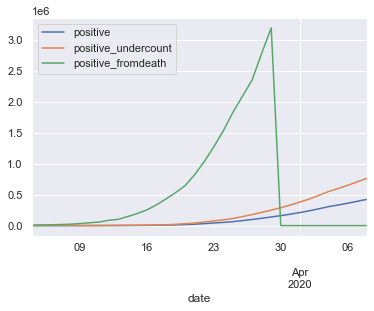

In [7]:
dfq.plot(x="date", y=["positive", "positive_undercount", "positive_fromdeath"])

,day_number,date,positive_predicted,positive,new_daily_positive,hospitalized_ident,icu_ident
35,36,2020-04-08,497995,423222.0,50941.0,49308,13149
36,37,2020-04-09,554739,0.0,56744.0,54927,14647
37,38,2020-04-10,617950,0.0,63211.0,61186,16316
38,39,2020-04-11,688364,0.0,70414.0,68158,18175
39,40,2020-04-12,766800,0.0,78436.0,75924,20246
40,41,2020-04-13,854175,0.0,87375.0,84575,22553
41,42,2020-04-14,951505,0.0,97330.0,94212,25123
42,43,2020-04-15,1059926,0.0,108421.0,104947,27986
43,44,2020-04-16,1180701,0.0,120775.0,116906,31175
44,45,2020-04-17,1315238,0.0,134537.0,130227,34727


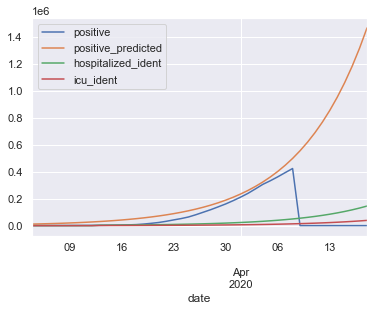

In [8]:
# Exponential Model
mp = ModelProjectionExponential()
d = mp.project(dfq, 10)
d.plot(x="date", y=["positive", "positive_predicted", "hospitalized_ident", "icu_ident"])
d.tail(11)

### SIR Fit

   direc: array([[-4.60587004e-03,  6.29926395e-04,  5.12926368e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.79392864e-03,  5.63807997e-04,  4.29814290e-01]])
     fun: 175876.98170171067
 message: 'Optimization terminated successfully.'
    nfev: 313
     nit: 6
  status: 0
 success: True
       x: array([0.28592779, 0.11121787, 4.39136062])
######################################################################
Day 0 = 2020-02-23 00:00:00  (today=36)
Doubling time is about 2.42 days
Recovery time is about 6.23 days
Estimated initial infection was order of 4,391 poeple


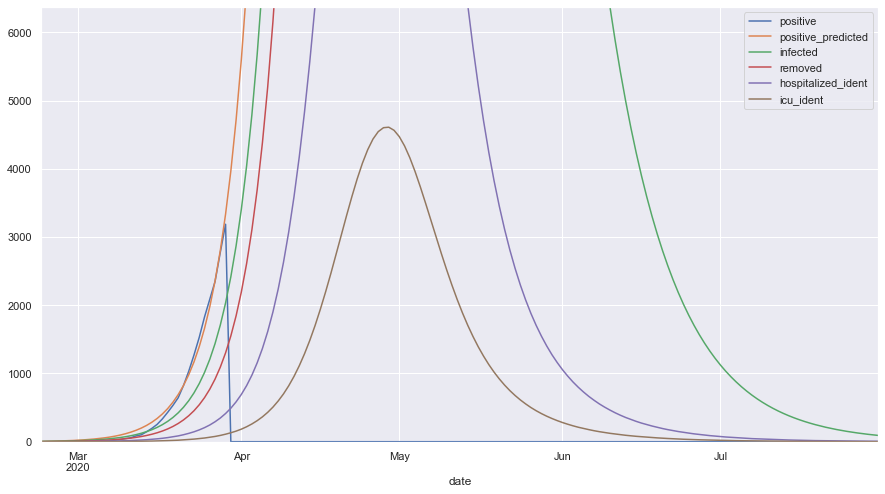

In [9]:
N=350000 
x0 = (0.25749545, 0.10952173, 3.17810689)  # beta, gamma, I0
c = ccd.fit_series/1000
start_date = dfq.date.values[0] - pd.Timedelta(days=ccd.shift)
sf = SIR()
(N, I0, R0, beta, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

### SIR4: Try Varying beta as part of the model

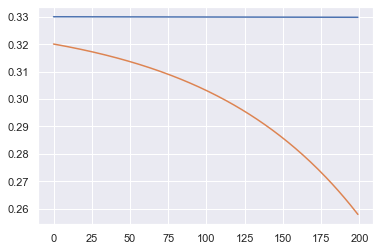

In [10]:
def g(alpha, beta0, t):
    return beta0 - alpha * t

def h(alpha, beta0, t):
    return beta0 - np.log(alpha) * alpha ** t

t = np.arange(0, 200, 1)
plt.plot(t, g(.000001, .33, t))
plt.plot(t, h(1.01, .33, t))
plt.show()

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[-2.23959648e-06,  1.76776723e-03,  8.45143748e-03,
         4.12997973e-02],
       [-8.91322933e-07,  1.68490104e-03,  4.73944352e-03,
         2.73461444e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.76057195e-07,  1.37662288e-04,  4.50204950e-04,
         2.57309923e-03]])
     fun: 19580.036411434863
 message: 'Optimization terminated successfully.'
    nfev: 1765
     nit: 30
  status: 0
 success: True
       x: array([4.42581999e-05, 7.31925949e-01, 4.84946490e-01, 3.92858218e-01])
######################################################################
Day 0 = 2020-02-23 00:00:00  (today=36)
Doubling time is about 2.42 days
Recovery time is about 1.43 days
Estimated initial infection was order of 392 poeple


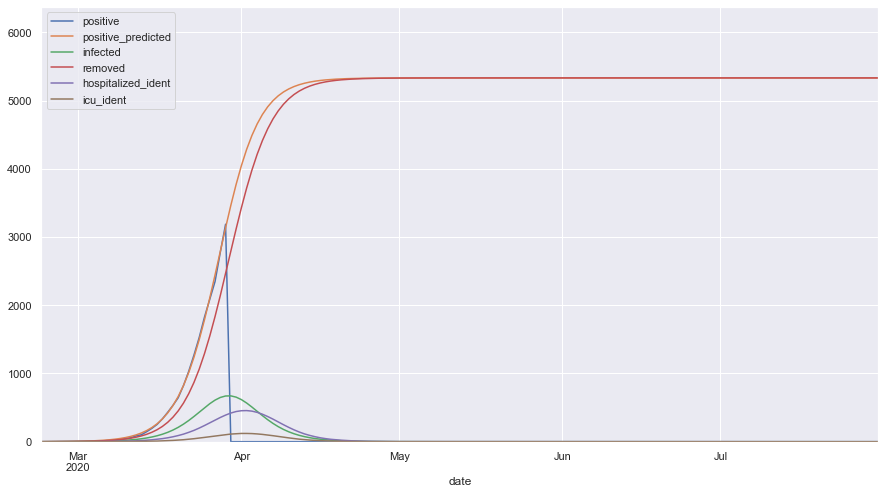

In [11]:
N=350000 
x0 = (0.01313296, 0.87278724, 0.33722395, 0.01900052)  # alpha, beta0, gamma, I0
c = ccd.fit_series/1000
start_date = dfq.date.values[0] - pd.Timedelta(days=ccd.shift)
sf = SIR4()
(N, I0, R0, beta0, alpha, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta0, alpha, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

In [12]:
dfw, wsl = get_dataset_df_from_files()
dfw.head()

,Entity,state,Date,positive,death,daily_new_death,date,last_update,daily_new_positive
0,Afghanistan,AFG,"Dec 31, 2019",0,0,0,2019-12-31,2020-04-10 00:23:35.284839,NaN
1,Afghanistan,AFG,"Jan 1, 2020",0,0,0,2020-01-01,2020-04-10 00:23:35.284839,0.0
2,Afghanistan,AFG,"Jan 2, 2020",0,0,0,2020-01-02,2020-04-10 00:23:35.284839,0.0
3,Afghanistan,AFG,"Jan 3, 2020",0,0,0,2020-01-03,2020-04-10 00:23:35.284839,0.0
4,Afghanistan,AFG,"Jan 4, 2020",0,0,0,2020-01-04,2020-04-10 00:23:35.284839,0.0


   direc: array([[-4.19121437e-03,  5.70242306e-04,  3.84900309e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.90807306e-03,  3.73998617e-04,  2.37531771e-01]])
     fun: 152791.0260210027
 message: 'Optimization terminated successfully.'
    nfev: 311
     nit: 6
  status: 0
 success: True
       x: array([0.33332148, 0.15366539, 3.43856957])
######################################################################
Day 0 = 2020-02-23 00:00:00  (today=100)
Doubling time is about 2.08 days
Recovery time is about 4.51 days
Estimated initial infection was order of 3,438 poeple


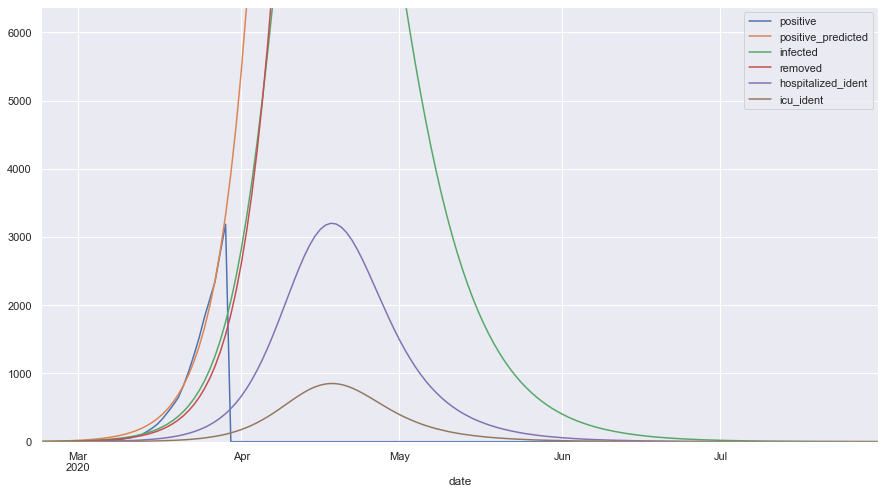

In [13]:
dfq = get_state_df(dfw, "ITA")
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq)
N=68000 
R0=0
x0 = (0.33821616, 0.15247499, 2.6568561)
sf = SIR()
(N, I0, R0, beta, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

   direc: array([[-4.19121437e-03,  5.70242306e-04,  3.84900309e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.90807306e-03,  3.73998617e-04,  2.37531771e-01]])
     fun: 152791.0260210027
 message: 'Optimization terminated successfully.'
    nfev: 311
     nit: 6
  status: 0
 success: True
       x: array([0.33332148, 0.15366539, 3.43856957])
######################################################################
Day 0 = 2020-02-23 00:00:00  (today=100)
Doubling time is about 2.08 days
Recovery time is about 4.51 days
Estimated initial infection was order of 3,438 poeple


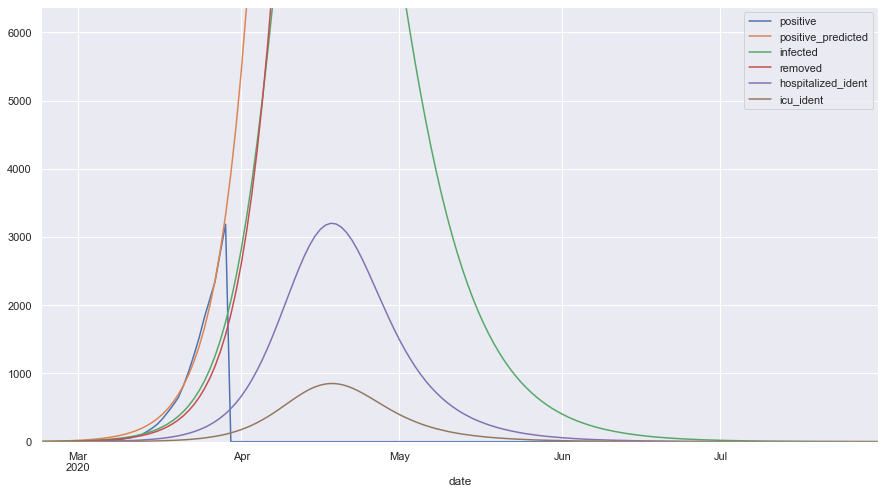

In [14]:
dfq = get_state_df(dfw, "ESP")
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq)
N=68000 
R0=0
x0 = (0.33821616, 0.15247499, 2.6568561 )
sf = SIR()
(N, I0, R0, beta, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])